### Aquiring and classifying daytime Landsat 8  Imagery for Burundi
The Descartes Labs API delivers a variety of image products, including Landsat8 Data: http://descartes-labs-python.readthedocs.io/en/latest/api.html

We will use satellite day and night time from 2017. Burundi's dry season spans June to late September. Imagery will be collected as close to August 15th, 2017 to minimize noise created from seasonality between the datasets and increase the likelhood the images will be cloud free.

In [2]:
import os
import warnings
from pprint import pprint

In [3]:
import descarteslabs as dl

In [4]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.find('burundi')
aoi = matches[0]
pprint(aoi)

# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
 'id': 85632285,
 'name': 'Burundi',
 'path': 'continent:africa_country:burundi',
 'placetype': 'country',
 'slug': 'africa_burundi'}


In [5]:
# Find potential matches
matches = dl.places.find('burundi')
pprint(matches)
# The first one looks good to me, so lets make that our area of interest.
aoi = matches[0]

[{'bbox': [29.001302, -4.468538, 30.849959, -2.309987],
  'id': 85632285,
  'name': 'Burundi',
  'path': 'continent:africa_country:burundi',
  'placetype': 'country',
  'slug': 'africa_burundi'}]


In [6]:
# This area of interest just gives us some basic properties such as bounding boxes.
# To access a GeoJSON Geometry object of that place, we call the `Places.shape` method, in this case
# accessing a low-resolution version of this particular shape.
shape = dl.places.shape(aoi['slug'], geom='low')

In [7]:
# What imagery is available?
sources = dl.metadata.sources()
pprint(sources)

[{'product': 'modis:09:CREFL', 'sat_id': 'Terra'},
 {'product': 'modis:09:CREFL', 'sat_id': 'Aqua'},
 {'product': 'sentinel-2:L1C', 'sat_id': 'S2A'},
 {'product': 'sentinel-2:L1C', 'sat_id': 'S2B'},
 {'product': 'landsat:LE07:PRE:TOAR', 'sat_id': 'LANDSAT_7'},
 {'product': 'landsat:LE07:PRE:TOAR', 'sat_id': 'Landsat7'},
 {'product': 'landsat:LT05:PRE:TOAR', 'sat_id': 'LANDSAT_5'},
 {'product': 'landsat:LT05:PRE:TOAR', 'sat_id': 'Landsat5'},
 {'product': 'sentinel-3:OLCI_RGB', 'sat_id': 'S3A'},
 {'product': 'landsat:LC08:PRE:TOAR', 'sat_id': 'LANDSAT_8'},
 {'product': 'sentinel-1:GRD', 'sat_id': 'SENTINEL-1A'},
 {'product': 'sentinel-1:GRD', 'sat_id': 'SENTINEL-1B'},
 {'product': 'usda:naip:rgbn', 'sat_id': 'NAIP'},
 {'product': 'usda:naip:rgbn:v1', 'sat_id': 'NAIP'},
 {'product': 'landsat:LC08:PRE:LaSRC', 'sat_id': 'L8SR'},
 {'product': 'landsat:LC08:01:RT:TOAR', 'sat_id': 'LANDSAT_8'},
 {'product': 'landsat:LE07:01:RT:TOAR', 'sat_id': 'LANDSAT_7'},
 {'product': 'landsat:LC08:01:T1:TOA

In [8]:
import json
feature_collection = dl.metadata.search(products='landsat:LC08:PRE:TOAR', start_time='2017-03-12',
                                        end_time='2017-03-20', limit=10, place=aoi['slug'])
# As the variable name implies, this returns a FeatureCollection GeoJSON dictionary.
# Its 'features' are the available scenes.
print (len(feature_collection['features']))
# The 'id' associated with each feature is a unique identifier into our imagery database.
# In this case there are two L8 scenes from adjoining WRS rows.
print ([f['id'] for f in feature_collection['features']])

3
['landsat:LC08:PRE:TOAR:meta_LC81730612017077_v1', 'landsat:LC08:PRE:TOAR:meta_LC81730622017077_v1', 'landsat:LC08:PRE:TOAR:meta_LC81730632017077_v1']


In [9]:
# Lets look at the first feature. The features are a FeatureCollection,
# so if we print it out we get a bunch of information. For example, we see that
# the overall cloud fraction is 1.2%.:
f0 = feature_collection['features'][0]
pprint(f0)

{'geometry': {'coordinates': [[[28.7556298, -0.417069],
                               [30.3681011, -0.7742422],
                               [29.999685, -2.4823087],
                               [28.3853223, -2.1216391],
                               [28.7556298, -0.417069]]],
              'type': 'Polygon'},
 'id': 'landsat:LC08:PRE:TOAR:meta_LC81730612017077_v1',
 'key': 'meta_LC81730612017077_v1',
 'properties': {'acquired': '2017-03-18T08:13:46.492131Z',
                'area': 35540.9,
                'bits_per_pixel': [1.384, 2.674, 0.941],
                'bright_fraction': 0.239,
                'bucket': 'gs://descartes-l8/',
                'cloud_fraction': 0.2482,
                'cloud_fraction_0': 0.2464,
                'cs_code': 'EPSG:32635',
                'descartes_version': 'hedj-landsat-0.9.7.4',
                'file_md5s': ['c26cccd6e7f01ef628a59d182c352374',
                              '1a52f696bd6a90a6157b1ee81cd63e59'],
                'file_sizes':

In [10]:
# Through visual inspection, I identified the best images to mosaic from the subset. 
north_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1'
south_east = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1'
north_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1'
south_west = 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1'
ids = [south_east,south_west, north_east,north_west]
print(ids)
# Collect the id's for each feature
# ids = [f['id'] for f in feature_collection['features']]
# Rasterize the features.
#  * Select red, green, blue, alpha
#  * Scale the incoming data with range [0, 10000] down to [0, 4000] (40% TOAR)
#  * Choose an output type of "Byte" (uint8)
#  * Choose 60m resolution
#  * Apply a cutline of Taos county
arr, meta = dl.raster.ndarray(
    ids,
    bands=['red', 'green', 'blue', 'alpha'],
    scales=[[0,4000], [0, 4000], [0, 4000], None],
    data_type='Byte',
    resolution=60,
    cutline=shape['geometry'],
)

# Note: A value of 1 in the alpha channel signifies where there is valid data.
# We use this throughout the majority of our imagery as a standard way of specifying
# valid or nodata regions. This is particularly helpful if a value of 0 in a particular
# band has meaning, rather than specifying a lack of data.

['landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172063_20170701_20170701_01_RT_v1', 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173063_20170606_20170616_01_T1_v1', 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_172062_20170701_20170701_01_RT_v1', 'landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_173062_20170606_20170616_01_T1_v1']


In [11]:
# We'll use matplotlib to make a quick plot of the image.
import matplotlib.pyplot as plt
%matplotlib inline

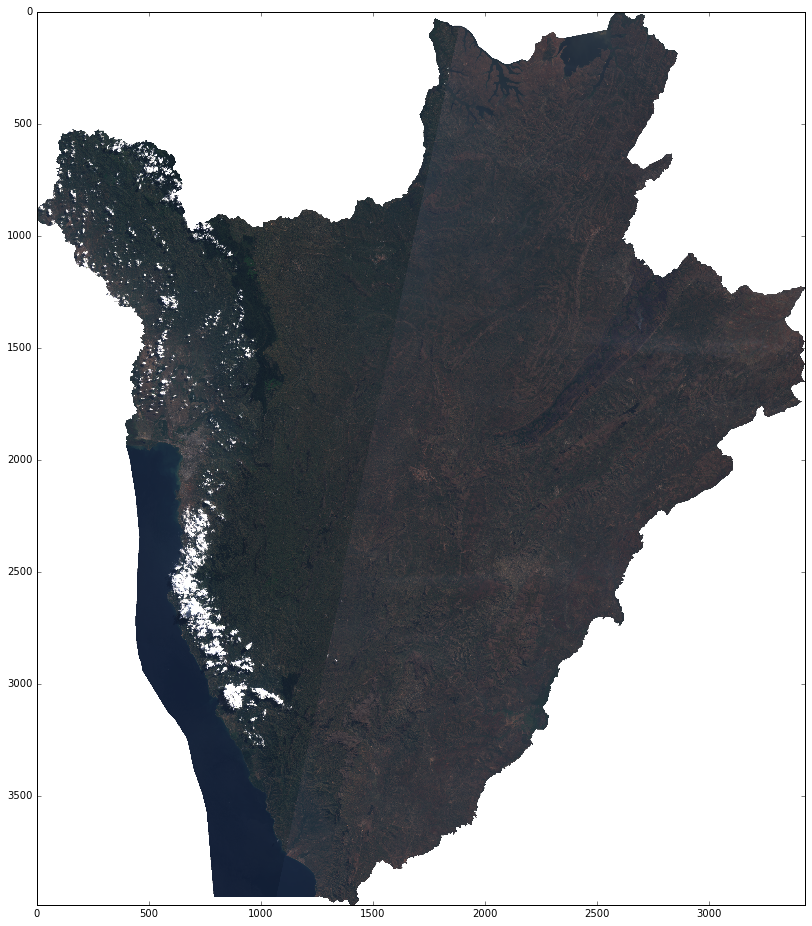

In [14]:
plt.figure(figsize=[16,16])
plt.imshow(arr)

### Train Model

In [12]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

TRAIN_DATA_PATH = "data/landsat/train/"
# TEST_DATA_PATH = "data/test/"

In [13]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels

Using the array derived from the descarteslabs api:

In [14]:
bands_data = arr
rows, cols, n_bands = bands_data.shape

Reading the image in from disc: 

In [53]:
RASTER_DATA_FILE = "data/landsat/landast_warped.tif"

In [ ]:
raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)

Return image after stretching or shrinking its intensity levels.

In [15]:
img = exposure.rescale_intensity(bands_data)

In [16]:
segments_quick = quickshift(img, kernel_size=7, max_dist=3, ratio=0.35, convert2lab=False)
n_segments = len(np.unique(segments_quick))
print(n_segments)

349466


In [21]:
print(segments_quick[1993][1715])

165387


<IPython.core.display.Javascript object>


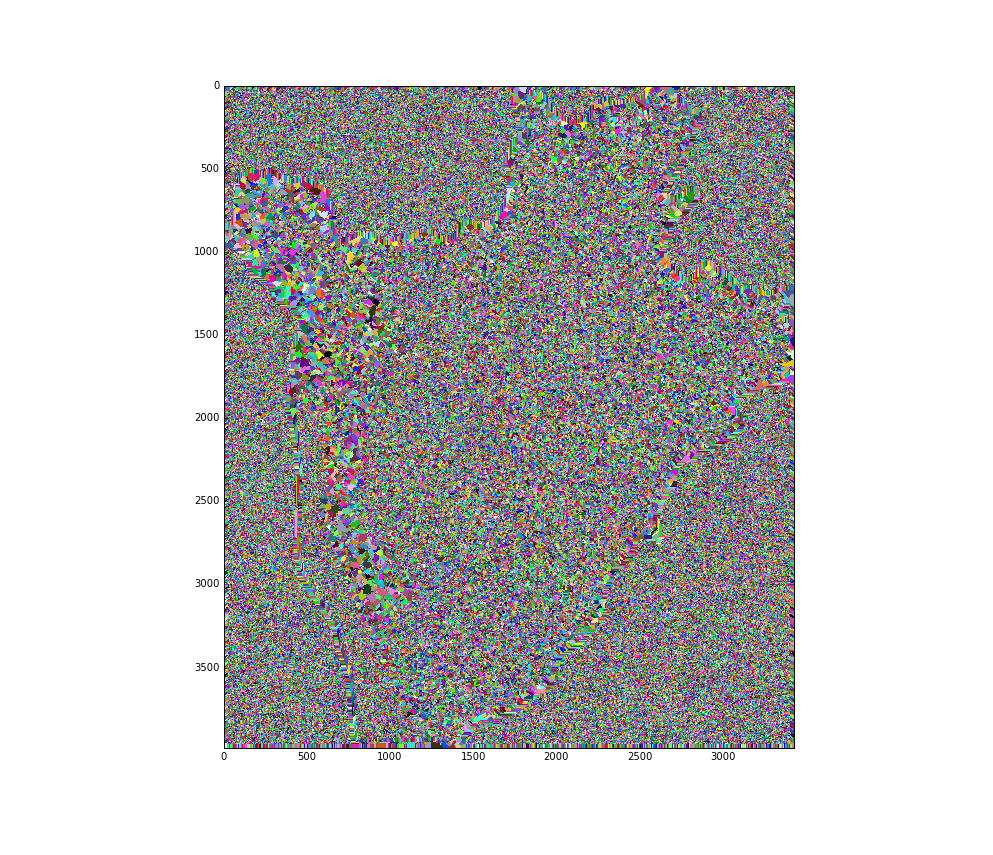

In [23]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))

plt.figure()
plt.imshow(segments_quick, interpolation='none', cmap=cmap)

#### Questions: 
1. The values range between 0 and 256, I was expecting a larger range. May have to do with Byte formate.